In [5]:
 # Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow
import tensorflow as tf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Import and read the CSV
df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [7]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
cols_dropped = ["EIN", "NAME"]
df.drop(columns=cols_dropped, inplace=True)
df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Preprocessing

In [8]:
# Determine the number of unique values in each column.
cols = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS', 'IS_SUCCESSFUL']

for col in cols:
    unique_count = df[col].nunique()
    value_counts = df[col].value_counts()
    print(f"Column: {col}\nUnique Values: {unique_count}\nValue Counts:\n{value_counts}\n")


Column: APPLICATION_TYPE
Unique Values: 17
Value Counts:
APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

Column: AFFILIATION
Unique Values: 6
Value Counts:
AFFILIATION
Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: count, dtype: int64

Column: CLASSIFICATION
Unique Values: 71
Value Counts:
CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64

Column: USE_CASE
Unique Values: 5
Value Counts:
USE_CASE
Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other    

In [9]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
df["APPLICATION_TYPE"].value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
T9,156


In [11]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
threshold = 500
app_type_counts = df["APPLICATION_TYPE"].value_counts()
application_types_to_replace = [app_type for app_type, count in app_type_counts.items() if count < threshold]

# Replace in dataframe
for app in application_types_to_replace:
    df['APPLICATION_TYPE'] = df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure replacement was successful
df['APPLICATION_TYPE'].value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
Other,276


In [12]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
df["CLASSIFICATION"].value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
...,...
C4120,1
C8210,1
C2561,1


In [13]:
# You may find it helpful to look at CLASSIFICATION value counts >1
class_counts = df["CLASSIFICATION"].value_counts()
class_counts.loc[class_counts > 1]

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
C7000,777
C1700,287
C4000,194
C5000,116


In [15]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
class_counts = df["CLASSIFICATION"].value_counts()
classifications_to_replace = [classification for classification, count in class_counts.items() if count < 200]

# Replace in dataframe
for cls in classifications_to_replace:
    df['CLASSIFICATION'] = df['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure replacement was successful
df['CLASSIFICATION'].value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
Other,1197
C7000,777
C1700,287


In [16]:
# Convert categorical data to numeric with `pd.get_dummies`
df2 = pd.get_dummies(df, dtype=int)
df2.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1700,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,108590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,5000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,6692,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,1,142590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [17]:
# Split our preprocessed data into our features and target arrays
X = df2.drop(columns=["IS_SUCCESSFUL"])
y = df2.IS_SUCCESSFUL

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (25724, 45), Test set shape: (8575, 45)


In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train["ASK_AMT"].values.reshape(-1, 1))

# Scale the data (only on ASK_AMT)
X_train_scaled = X_train.copy()
X_train_scaled["ASK_AMT"] = X_scaler.transform(X_train["ASK_AMT"].values.reshape(-1, 1))

X_test_scaled = X_test.copy()
X_test_scaled["ASK_AMT"] = X_scaler.transform(X_test["ASK_AMT"].values.reshape(-1, 1))

## Compile, Train and Evaluate the Model

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#  YOUR CODE GOES HERE

nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=5, activation="relu", input_dim=len(X.columns)))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=3, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train the model
fit_model = nn_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5318 - loss: 0.6919
Epoch 2/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5330 - loss: 0.6910
Epoch 3/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5319 - loss: 0.6911
Epoch 4/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5270 - loss: 0.6918
Epoch 5/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5319 - loss: 0.6911
Epoch 6/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5339 - loss: 0.6909
Epoch 7/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5273 - loss: 0.6917
Epoch 8/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5330 - loss: 0.6910
Epoch 9/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5388 - loss: 0.6902
Epoch 10/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5291 - loss: 0.6915


In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 2ms/step - accuracy: 0.5318 - loss: 0.6914
Loss: 0.6914495825767517, Accuracy: 0.5317784547805786


In [24]:
# Export our model to HDF5 file
nn_model.save("AlphabetSoupCharity.h5")

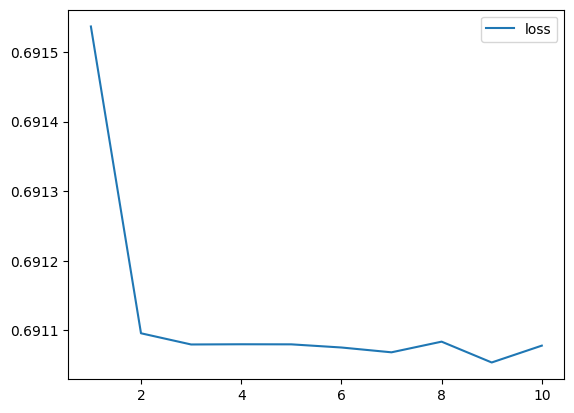

In [25]:
# Create historic DataFrame containing training history
hist_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the # of epochs
hist_df.index += 1

# Plot loss
hist_df.plot(y="loss")
plt.show()

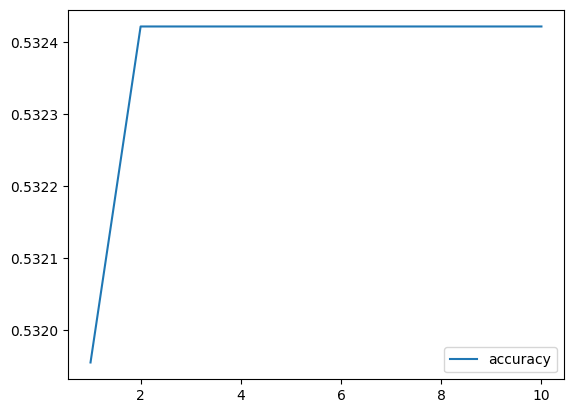

In [26]:
# Plot the accuracy
hist_df.plot(y="accuracy")
plt.show()